<a href="https://colab.research.google.com/github/EmKelsall/ADS2002---Catheter-Placement-Project/blob/Ryan/ranzcr_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install segmentation_models_pytorch

In [ ]:
import tensorflow as tf
import ast
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn.functional import relu
from torch.utils.data import Dataset
from PIL import Image
from tqdm import tqdm
import segmentation_models_pytorch as smp
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix
import seaborn as sns
import cv2
from scipy import interpolate

print(tf.__version__)

2.13.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# checking if gpu is working
device_name = tf.test.gpu_device_name()

if "GPU" not in device_name:
    print("GPU device not found")

print('Found GPU at: {}'.format(device_name))

print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU device not found
Found GPU at: 
GPU not available :(


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/ADS2002-Project-CatheterPlacement/Data/train.csv")
TRAIN_PATH = "/content/drive/MyDrive/ADS2002-Project-CatheterPlacement/Data/train"
anno_df = pd.read_csv("/content/drive/MyDrive/ADS2002-Project-CatheterPlacement/Data/train_annotations.csv")

In [ ]:
anno_df = anno_df[(anno_df['label'] == 'CVC - Normal') | (anno_df['label'] == 'CVC - Abnormal')]
anno_df["label"] = anno_df["label"].replace({"CVC - Normal": 1, "CVC - Abnormal": 0})
anno_df = anno_df.reset_index(drop=True)

In [ ]:
anno_df["label"].value_counts()

1    7437
0    1206
Name: label, dtype: int64

In [ ]:
anno_df

,StudyInstanceUID,label,data
0,1.2.826.0.1.3680043.8.498.12616281126973421762...,1,"[[1487, 1279], [1477, 1168], [1472, 1052], [14..."
1,1.2.826.0.1.3680043.8.498.12616281126973421762...,1,"[[1328, 7], [1347, 101], [1383, 193], [1400, 2..."
2,1.2.826.0.1.3680043.8.498.11697104485452001927...,1,"[[1366, 961], [1411, 861], [1453, 751], [1508,..."
3,1.2.826.0.1.3680043.8.498.87704688663091069148...,1,"[[906, 604], [1103, 578], [1242, 607], [1459, ..."
4,1.2.826.0.1.3680043.8.498.53113362093090654004...,1,"[[1152, 938], [1193, 856], [1265, 795], [1362,..."
...,...,...,...
8638,1.2.826.0.1.3680043.8.498.88885675487819792225...,1,"[[1384, 1098], [1480, 899], [1554, 774], [1630..."
8639,1.2.826.0.1.3680043.8.498.18590666552942008211...,1,"[[1250, 1105], [1247, 1031], [1248, 970], [126..."
8640,1.2.826.0.1.3680043.8.498.66774579023475418162...,1,"[[1379, 1402], [1389, 1233], [1386, 1137], [13..."
8641,1.2.826.0.1.3680043.8.498.18560506324214035535...,1,"[[1302, 1543], [1308, 1488], [1317, 1355], [13..."


In [ ]:
df_1 = anno_df[anno_df["label"] == 1]
df_0 = anno_df[anno_df["label"] == 0]

# Sample 300 rows from each DataFrame
sampled_1 = df_1.sample(n=1000, random_state=42)  # Using random_state for reproducibility
sampled_0 = df_0.sample(n=1000, random_state=42)

# Concatenate the samples to get a balanced subset
anno_df = pd.concat([sampled_1, sampled_0]).reset_index(drop=True)

test = anno_df.sample(frac=0.15, random_state=42)
anno_df = anno_df.drop(test.index).reset_index(drop=True)
test = test.reset_index(drop=True)
valid = anno_df.sample(frac=0.1, random_state=42)
anno_df = anno_df.drop(valid.index).reset_index(drop=True)
valid = valid.reset_index(drop=True)

In [ ]:
# columns_to_drop = ['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline', 'NGT - Normal',
#                   "NGT - Incompletely Imaged", "Swan Ganz Catheter Present", "PatientID", "CVC - Borderline", 'CVC - Abnormal']

# df = df.drop(columns=columns_to_drop, axis = 1)

# df_0 = df[df["CVC - Normal"] == 0]
# df_1 = df[df["CVC - Normal"] == 1]

# # Sample 300 rows from each DataFrame
# sampled_0 = df_0.sample(n=350, random_state=42)  # Using random_state for reproducibility
# sampled_1 = df_1.sample(n=350, random_state=42)

# # Concatenate the samples to get a balanced subset
# df = pd.concat([sampled_0, sampled_1]).reset_index(drop=True)

# test = df.sample(frac=0.15, random_state=42)
# df = df.drop(test.index).reset_index(drop=True)
# test = test.reset_index(drop=True)
# valid = df.sample(frac=0.1, random_state=42)
# df = df.drop(valid.index).reset_index(drop=True)
# valid = valid.reset_index(drop=True)

In [ ]:
# multiple cathetrers per patient
matches_in_test = anno_df['StudyInstanceUID'].isin(test['StudyInstanceUID']).sum()
print("test matches:", matches_in_test)

matches_in_val = anno_df['StudyInstanceUID'].isin(valid['StudyInstanceUID']).sum()
print("valid matches:", matches_in_val)

test matches: 22
valid matches: 13


In [ ]:
print("train", anno_df["label"].value_counts())
print("valid", valid["label"].value_counts())
print("test", test["label"].value_counts())

train 1    768
0    762
Name: label, dtype: int64
valid 0    87
1    83
Name: label, dtype: int64
test 0    151
1    149
Name: label, dtype: int64


In [ ]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

In [ ]:
def _parse_annotation(raw):
    annotation = ast.literal_eval(raw)
    annotation = np.array(annotation, dtype=np.int32)
    annotation = np.expand_dims(annotation, axis=0)
    return annotation

In [ ]:
def scale_annotations(annotation, original_shape, target_shape):
    ratio_y = target_shape[0] / original_shape[0]
    ratio_x = target_shape[1] / original_shape[1]
    annotation_scaled = [[int(x*ratio_x), int(y*ratio_y)] for [x, y] in annotation]
    return annotation_scaled

def annotate(img, target, annotation):
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    original_shape = img.shape[:2]
    annotation = _parse_annotation(annotation)
    annotation = annotation[0]
    # annotation = scale_annotations(annotation, original_shape, (256, 256))
    # print(annotation)
    img = cv2.polylines(img, [np.array(annotation)], False, color=(255, 0, 0), thickness=10)
    return img


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, anno_df):
        self.anno_df = anno_df
        self.anno_file_names = anno_df["StudyInstanceUID"].values
        self.labels = anno_df['label'].values

    def __len__(self):
        return len(self.anno_df)

    def __getitem__(self, idx):
        file_name = self.anno_file_names[idx]
        image_path = f"{TRAIN_PATH}/{file_name}.jpg"

        image = cv2.imread(image_path)
        image = annotate(image, self.anno_df["label"][idx], self.anno_df["data"][idx])
        image = cv2.resize(image, (256,256))
        image = np.asarray(image, dtype=np.float32) / 255.0
        image = (image - imagenet_mean) / imagenet_std

        labels = torch.tensor(self.labels[idx]).float()
        return image, torch.tensor(labels)

In [ ]:
class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['StudyInstanceUID'].values
        self.labels = df['label'].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        image_path = f"{TRAIN_PATH}/{file_name}.jpg"

        image = cv2.imread(image_path)
        image = cv2.resize(image, (256,256))
        image = np.asarray(image, dtype=np.float32) / 255.0
        image = (image - imagenet_mean) / imagenet_std

        labels = torch.tensor(self.labels[idx]).float()
        return image, torch.tensor(labels)

In [ ]:
train_dataset = CustomDataset(anno_df)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

valid_dataset = CustomDataset(valid)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True)

test_dataset = CustomDataset(test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
test_no_annot = TestDataset(test)
test_loader_no_annot = torch.utils.data.DataLoader(test_no_annot, batch_size=8, shuffle=False)

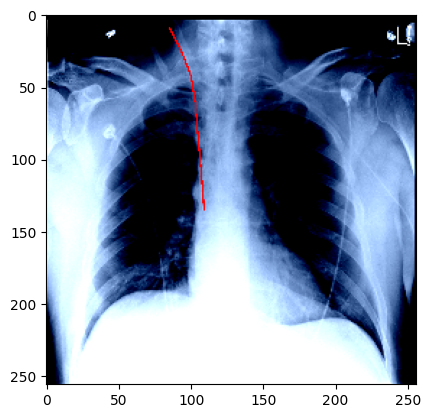

In [ ]:
plt.imshow(train_dataset[5][0])

In [ ]:
train_dataset[15][0].shape

(256, 256, 3)

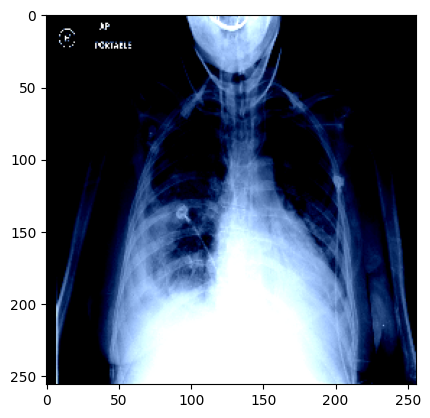

In [ ]:
plt.imshow(test_no_annot[10][0])

In [ ]:
img_test = train_dataset[2][0]
img_test = img_test.astype(np.uint8)
img_test.shape

(256, 256, 3)

In [ ]:
device = "cuda"

In [ ]:
model = smp.Unet("efficientnet-b3", encoder_weights="imagenet", classes=3, in_channels=3, aux_params = dict(classes = 1, dropout=0.1, pooling = "max"))
model = model.to(device)

RuntimeError: ignored

In [ ]:
optim = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.BCEWithLogitsLoss()
sigmoid = torch.nn.Sigmoid()

In [ ]:
def train(model, trainloader, epochs: int, valloader):
    model.train()
    train_loss_list = []
    train_accuracy_list = []
    val_loss_list = []
    val_accuracy_list = []


    for epoch in tqdm(range(epochs), position=0, leave=True, desc="Epochs"):
        total_samples = 0
        epoch_loss = 0
        num_matches = 0

        for data in trainloader:
            inputs, labels = data
            inputs = inputs.unsqueeze(1) # adds channel dimension to work with unet input
            inputs = inputs.permute(0, 4, 2, 3, 1)
            inputs = inputs.squeeze(-1)  # this removes the unnecessary channel dimension
            inputs = inputs.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(device)

            optim.zero_grad()
            _, outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))

            loss.backward()
            optim.step()

            labels = labels.long()
            probabilities = sigmoid(outputs)
#             print("labels", labels)
            threshold = 0.50
            predicted = (probabilities > threshold).float()
            predicted = predicted.view(-1,1)
            predicted = predicted.squeeze()
#             print("preds", predicted)
            matching_indices = (labels == predicted)
#             print("matching_indices", matching_indices)
            num_matches += matching_indices.sum().item()
#             print("num_matches", num_matches)
            total_samples += labels.size(0)
#             print("total_samples", total_samples)

            epoch_loss += loss.item()

        train_accuracy = num_matches / total_samples
        train_accuracy_list.append(train_accuracy)
        train_loss_list.append(epoch_loss)
#         print("Training - epoch num", epoch + 1, "done!")

         # Validation
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            val_loss = 0
            val_matches = 0
            val_samples = 0

            for data in valloader:
                inputs, labels = data
                inputs = inputs.unsqueeze(1)  # adds channel dimension to work with unet input
                inputs = inputs.permute(0, 4, 2, 3, 1)
                inputs = inputs.squeeze(-1)  # this removes the unnecessary channel dimension
                inputs = inputs.to(device)
                inputs = inputs.to(torch.float32)
                labels = labels.to(device)

                _, outputs = model(inputs)
                loss = criterion(outputs, labels.unsqueeze(1))

                labels = labels.long()
#                 print("labels", labels)
                probabilities = sigmoid(outputs)
                threshold = 0.50
                predicted = (probabilities > threshold).float()
                predicted = predicted.view(-1,1)
                predicted = predicted.squeeze()
                matching_indices = (labels == predicted)

                val_matches += matching_indices.sum().item()
                val_samples += labels.size(0)
                val_loss += loss.item()

            val_accuracy = val_matches / val_samples
            val_accuracy_list.append(val_accuracy)
            val_loss_list.append(val_loss)

        model.train()


    return train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list

In [ ]:
epochs = 25

In [ ]:
train_loss, train_acc, val_loss, val_acc = train(model, train_loader, epochs, valid_loader)

In [ ]:
# custom_palette = ['#D3E0EA', '#AAB8C4', '#8498A2', '#5D7D88', '#3C6270',
#                   '#1F465E', '#132D4B', '#0A1C36', '#051024', '#020916']

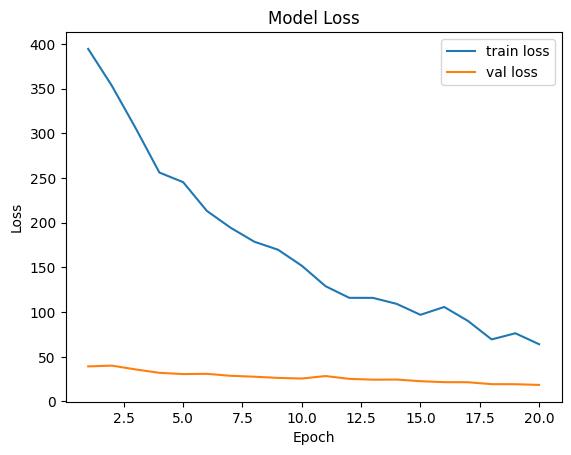

In [ ]:
plt.plot(range(1,epochs+1), train_loss, label="train loss")
plt.plot(range(1,epochs+1), val_loss, label="val loss")
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend();

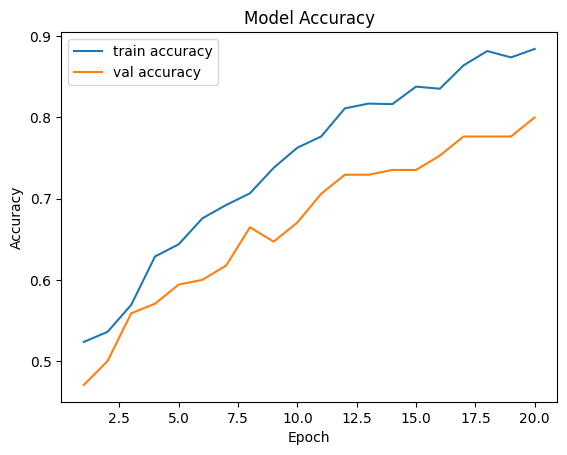

In [ ]:
plt.plot(range(1,epochs+1), train_acc, label = "train accuracy")
plt.plot(range(1,epochs+1), val_acc, label = "val accuracy")
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend();

In [ ]:
print("train_loss", train_loss)
print("train_acc", train_acc)
print("valid_loss", val_loss)
print("valid_acc", val_acc)

train_loss [394.46800051629543, 353.11748134344816, 305.8045287504792, 256.15733351558447, 245.40967698022723, 213.23831797018647, 194.42731864005327, 178.76673848740757, 169.78691174834967, 151.90769063588232, 129.02073660842143, 115.99207521905191, 115.92130426433869, 109.20975567516871, 96.9823572000023, 105.76746124529745, 90.17836793069728, 69.43906404697373, 76.3379799923132, 64.04926557370345]
train_acc [0.5235294117647059, 0.5359477124183006, 0.569281045751634, 0.6287581699346405, 0.6437908496732027, 0.6758169934640523, 0.692156862745098, 0.7065359477124183, 0.7379084967320262, 0.7627450980392156, 0.7764705882352941, 0.8111111111111111, 0.8169934640522876, 0.8163398692810457, 0.8379084967320262, 0.8352941176470589, 0.8640522875816994, 0.8816993464052287, 0.8738562091503268, 0.884313725490196]
valid_loss [39.24534550309181, 40.131999880075455, 35.85023429989815, 32.084457870572805, 30.67240969464183, 30.928513944149017, 28.75724846124649, 27.727577202022076, 26.38413217663765, 2

In [ ]:
torch.save(model.state_dict(), 'UNet_model_efficient_better.pth')

In [ ]:
def evaluate(model, test_loader):
    """
    Evaluates the model on the given validation loader.

    Args:
    - model (torch.nn.Module): The model to evaluate.
    - val_loader (torch.utils.data.DataLoader): DataLoader for validation data.

    Returns:
    - Tuple[float, float]: Returns validation loss and accuracy.
    """

    model.eval()

    num_matches = 0
    total_samples = 0
    labels_list = []
    pred_list = []

    with torch.no_grad():
        for data in tqdm(test_loader):

            inputs, labels = data
            inputs = inputs.unsqueeze(1) # adds channel dimension to work with unet input
            inputs = inputs.permute(0, 4, 2, 3, 1)
            inputs = inputs.squeeze(-1)  # this removes the unnecessary channel dimension
            inputs = inputs.to(device)  # moved inputs to device
            inputs = inputs.to(torch.float32)
            labels = labels.to(device)  # moved labels to device
            print("labels", labels)
            _, outputs = model(inputs)
#             print("labels", labels)

            labels = labels.long()
            threshold = 0.50
            probabilities = sigmoid(outputs)
            print(probabilities)
            predicted = (probabilities > threshold).float()
            predicted = predicted.view(-1,1)
            predicted = predicted.squeeze()
            labels_list.append(labels)
            pred_list.append(predicted)
            matching_indices = (labels == predicted)
            num_matches += matching_indices.sum().item()
            total_samples += labels.size(0)

    accuracy = num_matches / total_samples

    return accuracy, labels_list, pred_list

In [ ]:
test_acc, labels, preds = evaluate(model, test_loader)

  3%|▎         | 1/38 [00:00<00:16,  2.18it/s]

labels tensor([0., 1., 0., 1., 0., 0., 1., 0.], device='cuda:0')
tensor([[4.4658e-05],
        [9.9857e-01],
        [5.4186e-02],
        [9.7481e-01],
        [5.3744e-04],
        [3.5874e-04],
        [8.7535e-01],
        [1.2033e-08]], device='cuda:0')


  5%|▌         | 2/38 [00:00<00:16,  2.24it/s]

labels tensor([1., 0., 1., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([[9.5453e-01],
        [5.2274e-01],
        [9.9099e-01],
        [9.2101e-01],
        [2.0417e-07],
        [9.9381e-01],
        [9.9989e-01],
        [1.2935e-02]], device='cuda:0')


  8%|▊         | 3/38 [00:01<00:15,  2.30it/s]

labels tensor([1., 1., 0., 0., 1., 0., 0., 0.], device='cuda:0')
tensor([[9.9345e-02],
        [9.4032e-01],
        [9.6463e-01],
        [1.6418e-01],
        [9.9916e-01],
        [2.7480e-05],
        [3.6969e-02],
        [3.4788e-11]], device='cuda:0')


 11%|█         | 4/38 [00:01<00:14,  2.39it/s]

labels tensor([0., 1., 0., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([[0.9692],
        [0.9916],
        [0.0286],
        [0.9517],
        [1.0000],
        [1.0000],
        [0.4573],
        [0.9757]], device='cuda:0')


 13%|█▎        | 5/38 [00:02<00:14,  2.31it/s]

labels tensor([1., 1., 0., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([[1.0000e+00],
        [9.9412e-01],
        [3.5836e-06],
        [9.9999e-01],
        [9.9879e-01],
        [7.5230e-05],
        [8.9477e-01],
        [4.8793e-01]], device='cuda:0')


 16%|█▌        | 6/38 [00:02<00:13,  2.31it/s]

labels tensor([1., 0., 1., 1., 0., 1., 1., 1.], device='cuda:0')
tensor([[0.9512],
        [0.0016],
        [0.9999],
        [0.9674],
        [0.3029],
        [0.9983],
        [0.8080],
        [0.0557]], device='cuda:0')


 18%|█▊        | 7/38 [00:03<00:13,  2.28it/s]

labels tensor([1., 0., 0., 1., 0., 1., 1., 0.], device='cuda:0')
tensor([[9.3817e-01],
        [9.5901e-01],
        [8.5369e-01],
        [7.1146e-01],
        [3.9855e-01],
        [9.9515e-01],
        [3.9995e-02],
        [8.5037e-07]], device='cuda:0')


 21%|██        | 8/38 [00:03<00:12,  2.33it/s]

labels tensor([0., 0., 0., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([[1.8272e-07],
        [1.5846e-09],
        [2.1871e-01],
        [9.4465e-01],
        [9.5732e-01],
        [7.0730e-01],
        [2.9527e-01],
        [9.9198e-01]], device='cuda:0')


 24%|██▎       | 9/38 [00:03<00:12,  2.35it/s]

labels tensor([0., 0., 1., 0., 1., 0., 0., 1.], device='cuda:0')
tensor([[1.1949e-03],
        [4.4541e-02],
        [6.8895e-01],
        [5.0905e-03],
        [1.0000e+00],
        [1.9970e-05],
        [4.7582e-03],
        [9.8273e-01]], device='cuda:0')


 26%|██▋       | 10/38 [00:04<00:11,  2.35it/s]

labels tensor([0., 0., 1., 1., 0., 1., 1., 0.], device='cuda:0')
tensor([[9.5793e-01],
        [2.3935e-05],
        [8.4443e-01],
        [9.3879e-01],
        [2.3485e-05],
        [1.3555e-03],
        [9.7334e-01],
        [2.4188e-02]], device='cuda:0')


 29%|██▉       | 11/38 [00:04<00:11,  2.37it/s]

labels tensor([1., 1., 0., 0., 0., 0., 0., 1.], device='cuda:0')
tensor([[9.9423e-01],
        [5.0071e-02],
        [1.0125e-03],
        [5.1735e-01],
        [6.0802e-01],
        [1.1345e-06],
        [9.9929e-01],
        [9.4550e-01]], device='cuda:0')


 32%|███▏      | 12/38 [00:05<00:10,  2.38it/s]

labels tensor([1., 0., 0., 0., 1., 1., 0., 0.], device='cuda:0')
tensor([[9.0564e-01],
        [9.3656e-01],
        [9.5999e-01],
        [9.6099e-03],
        [9.5697e-01],
        [9.8457e-01],
        [2.0529e-05],
        [2.5029e-07]], device='cuda:0')


 34%|███▍      | 13/38 [00:05<00:10,  2.35it/s]

labels tensor([1., 0., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([[6.8118e-01],
        [6.5264e-07],
        [2.4669e-05],
        [9.1142e-04],
        [1.7204e-01],
        [9.0784e-01],
        [8.2472e-01],
        [4.5900e-04]], device='cuda:0')


 37%|███▋      | 14/38 [00:05<00:10,  2.35it/s]

labels tensor([1., 1., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([[0.3647],
        [1.0000],
        [0.9997],
        [1.0000],
        [0.9974],
        [0.0208],
        [0.9753],
        [0.0220]], device='cuda:0')


 39%|███▉      | 15/38 [00:06<00:09,  2.32it/s]

labels tensor([0., 0., 1., 1., 0., 1., 1., 0.], device='cuda:0')
tensor([[1.2851e-10],
        [1.0503e-08],
        [9.9749e-01],
        [9.9951e-01],
        [1.9934e-04],
        [9.9197e-01],
        [1.2422e-01],
        [6.3782e-01]], device='cuda:0')


 42%|████▏     | 16/38 [00:06<00:09,  2.43it/s]

labels tensor([0., 0., 0., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([[0.0048],
        [0.0019],
        [0.0014],
        [0.0344],
        [1.0000],
        [0.3420],
        [0.9999],
        [0.9682]], device='cuda:0')


 45%|████▍     | 17/38 [00:07<00:08,  2.48it/s]

labels tensor([0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([[5.5632e-04],
        [6.8748e-01],
        [5.9475e-06],
        [3.1521e-05],
        [9.9956e-01],
        [8.2631e-01],
        [9.9826e-01],
        [8.3423e-08]], device='cuda:0')


 47%|████▋     | 18/38 [00:07<00:08,  2.37it/s]

labels tensor([0., 0., 0., 0., 0., 1., 0., 1.], device='cuda:0')
tensor([[9.4541e-01],
        [2.1830e-04],
        [6.9344e-08],
        [5.1725e-04],
        [8.2750e-03],
        [9.9999e-01],
        [1.1015e-04],
        [9.9993e-01]], device='cuda:0')


 50%|█████     | 19/38 [00:08<00:09,  2.05it/s]

labels tensor([0., 1., 1., 0., 1., 1., 0., 1.], device='cuda:0')
tensor([[1.8347e-05],
        [1.0000e+00],
        [6.6601e-01],
        [8.4572e-05],
        [8.2895e-01],
        [9.9329e-01],
        [1.1250e-06],
        [9.9862e-01]], device='cuda:0')


 53%|█████▎    | 20/38 [00:08<00:09,  1.91it/s]

labels tensor([1., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([[8.0150e-01],
        [1.1484e-04],
        [9.9994e-01],
        [5.2104e-01],
        [7.2037e-01],
        [3.0544e-04],
        [9.9644e-01],
        [8.6407e-01]], device='cuda:0')


 55%|█████▌    | 21/38 [00:09<00:09,  1.79it/s]

labels tensor([1., 1., 1., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([[1.0000],
        [0.9941],
        [1.0000],
        [0.9979],
        [0.2506],
        [0.0014],
        [0.0315],
        [0.0316]], device='cuda:0')


 58%|█████▊    | 22/38 [00:10<00:09,  1.73it/s]

labels tensor([1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0')
tensor([[9.9928e-01],
        [4.1153e-02],
        [9.0676e-05],
        [9.9998e-01],
        [5.8613e-06],
        [2.6347e-01],
        [8.9885e-01],
        [2.7408e-02]], device='cuda:0')


 61%|██████    | 23/38 [00:10<00:09,  1.66it/s]

labels tensor([1., 0., 1., 0., 0., 1., 0., 0.], device='cuda:0')
tensor([[9.9880e-01],
        [1.1260e-04],
        [9.9999e-01],
        [6.5173e-08],
        [6.1769e-01],
        [1.0000e+00],
        [2.1616e-03],
        [6.0722e-01]], device='cuda:0')


 63%|██████▎   | 24/38 [00:11<00:08,  1.66it/s]

labels tensor([1., 1., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([[9.9981e-01],
        [6.2895e-01],
        [9.9736e-01],
        [9.8076e-04],
        [1.2091e-03],
        [3.9815e-03],
        [3.1611e-03],
        [9.9999e-01]], device='cuda:0')


 66%|██████▌   | 25/38 [00:11<00:07,  1.79it/s]

labels tensor([0., 1., 1., 1., 0., 1., 1., 0.], device='cuda:0')
tensor([[4.8342e-05],
        [2.9040e-05],
        [9.9957e-01],
        [1.9078e-02],
        [8.6270e-06],
        [9.9825e-01],
        [4.3052e-02],
        [3.5328e-05]], device='cuda:0')


 68%|██████▊   | 26/38 [00:12<00:06,  1.93it/s]

labels tensor([0., 1., 1., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([[7.2543e-03],
        [6.8873e-02],
        [1.0000e+00],
        [9.9943e-01],
        [9.9208e-01],
        [1.0000e+00],
        [9.4536e-01],
        [1.9886e-04]], device='cuda:0')


 71%|███████   | 27/38 [00:12<00:05,  2.02it/s]

labels tensor([0., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([[0.0038],
        [0.9993],
        [0.8635],
        [0.9560],
        [0.9997],
        [1.0000],
        [1.0000],
        [0.0105]], device='cuda:0')


 74%|███████▎  | 28/38 [00:13<00:04,  2.13it/s]

labels tensor([0., 1., 1., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([[5.7911e-06],
        [8.5019e-01],
        [9.6399e-01],
        [5.2357e-02],
        [8.7799e-01],
        [9.9788e-01],
        [1.1748e-02],
        [9.7183e-01]], device='cuda:0')


 76%|███████▋  | 29/38 [00:13<00:04,  2.15it/s]

labels tensor([0., 0., 1., 1., 0., 1., 0., 1.], device='cuda:0')
tensor([[4.5862e-06],
        [2.5767e-02],
        [9.8773e-01],
        [6.2733e-01],
        [1.6830e-01],
        [9.9719e-01],
        [6.6997e-03],
        [9.9992e-01]], device='cuda:0')


 79%|███████▉  | 30/38 [00:14<00:03,  2.20it/s]

labels tensor([0., 0., 0., 1., 0., 1., 0., 1.], device='cuda:0')
tensor([[3.7331e-04],
        [7.9426e-04],
        [3.1021e-01],
        [9.9850e-01],
        [2.8474e-06],
        [2.6180e-05],
        [9.5817e-01],
        [9.9964e-01]], device='cuda:0')


 82%|████████▏ | 31/38 [00:14<00:03,  2.30it/s]

labels tensor([1., 0., 1., 1., 0., 1., 1., 0.], device='cuda:0')
tensor([[2.2391e-01],
        [7.8441e-03],
        [1.0000e+00],
        [9.9989e-01],
        [1.0317e-04],
        [9.9972e-01],
        [9.9999e-01],
        [3.3265e-02]], device='cuda:0')


 84%|████████▍ | 32/38 [00:14<00:02,  2.26it/s]

labels tensor([1., 0., 0., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([[1.4624e-01],
        [1.2944e-04],
        [6.0626e-01],
        [7.9606e-01],
        [3.3316e-06],
        [8.4300e-01],
        [9.3378e-06],
        [1.3236e-02]], device='cuda:0')


 87%|████████▋ | 33/38 [00:15<00:02,  2.31it/s]

labels tensor([1., 1., 0., 0., 1., 0., 1., 0.], device='cuda:0')
tensor([[5.4946e-01],
        [9.6416e-01],
        [5.6577e-01],
        [6.7751e-05],
        [1.2860e-03],
        [1.1949e-08],
        [3.4548e-01],
        [9.9775e-01]], device='cuda:0')


 89%|████████▉ | 34/38 [00:15<00:01,  2.32it/s]

labels tensor([0., 0., 1., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([[1.6956e-01],
        [2.5364e-03],
        [9.9973e-01],
        [9.9464e-01],
        [9.9669e-01],
        [1.6650e-04],
        [5.2562e-05],
        [3.9553e-02]], device='cuda:0')


 92%|█████████▏| 35/38 [00:16<00:01,  2.40it/s]

labels tensor([1., 0., 0., 0., 1., 1., 0., 1.], device='cuda:0')
tensor([[2.6670e-03],
        [1.2750e-04],
        [3.9263e-02],
        [4.1323e-05],
        [1.0000e+00],
        [9.9997e-01],
        [6.8956e-06],
        [9.5155e-01]], device='cuda:0')


 95%|█████████▍| 36/38 [00:16<00:00,  2.41it/s]

labels tensor([0., 0., 1., 0., 0., 1., 1., 0.], device='cuda:0')
tensor([[9.8093e-01],
        [6.2354e-02],
        [9.9984e-01],
        [9.1158e-01],
        [6.7100e-05],
        [6.0237e-01],
        [9.9924e-01],
        [1.7054e-07]], device='cuda:0')


 97%|█████████▋| 37/38 [00:16<00:00,  2.45it/s]

labels tensor([1., 1., 0., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([[9.9997e-01],
        [9.5877e-01],
        [1.3543e-04],
        [5.5927e-03],
        [9.9966e-01],
        [3.0701e-01],
        [7.7974e-01],
        [9.4908e-01]], device='cuda:0')


100%|██████████| 38/38 [00:17<00:00,  2.21it/s]

labels tensor([1., 0., 0., 1.], device='cuda:0')
tensor([[0.0216],
        [0.4778],
        [0.2626],
        [0.0012]], device='cuda:0')


In [ ]:
test_acc

0.8

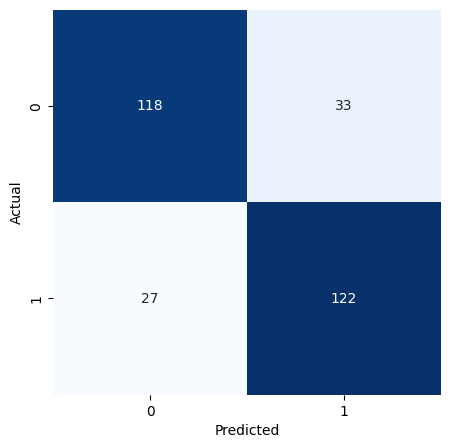

In [ ]:
preds_tensor = torch.cat(preds).cpu().numpy()
labels_tensor = torch.cat(labels).cpu().numpy()

# Compute the confusion matrix
cm = confusion_matrix(labels_tensor, preds_tensor)

# Visualize the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()